<a href="https://colab.research.google.com/github/Nickguild1993/machine_learning_models/blob/main/ClassificationModels_WineDS_SCALED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

****USING SCALED X_train / X_test for ALL tests****

In [1]:
# importing libraries

# numpy and pandas are always going to be imported- they're the basis for pretty much all
# analysis that you can do in python.
import numpy as np
import pandas as pd
import sklearn
# matplotlib & seaborn are for visualizations (seaborn is built on matplotlib, but it's much more versatile)
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn (machine learning library) importing various models and tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# %matplotlib inline keeps your graphs within the parameters of the notebook among other benefits
%matplotlib inline




In [2]:
# import data

from google.colab import files
uploaded = files.upload()

Saving classification_ds_wine.csv to classification_ds_wine.csv


In [3]:
# create a DataFrame
import io

df = pd.read_csv(io.BytesIO(uploaded["classification_ds_wine.csv"]))
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Exploratory Data Analysis

In [4]:
df["quality"].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [5]:
df.info()
# no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
# Checking the shape of the DataFrame

print(df.shape)

print("There are 1599 rows and 12 columns")

(1599, 12)
There are 1599 rows and 12 columns


In [7]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


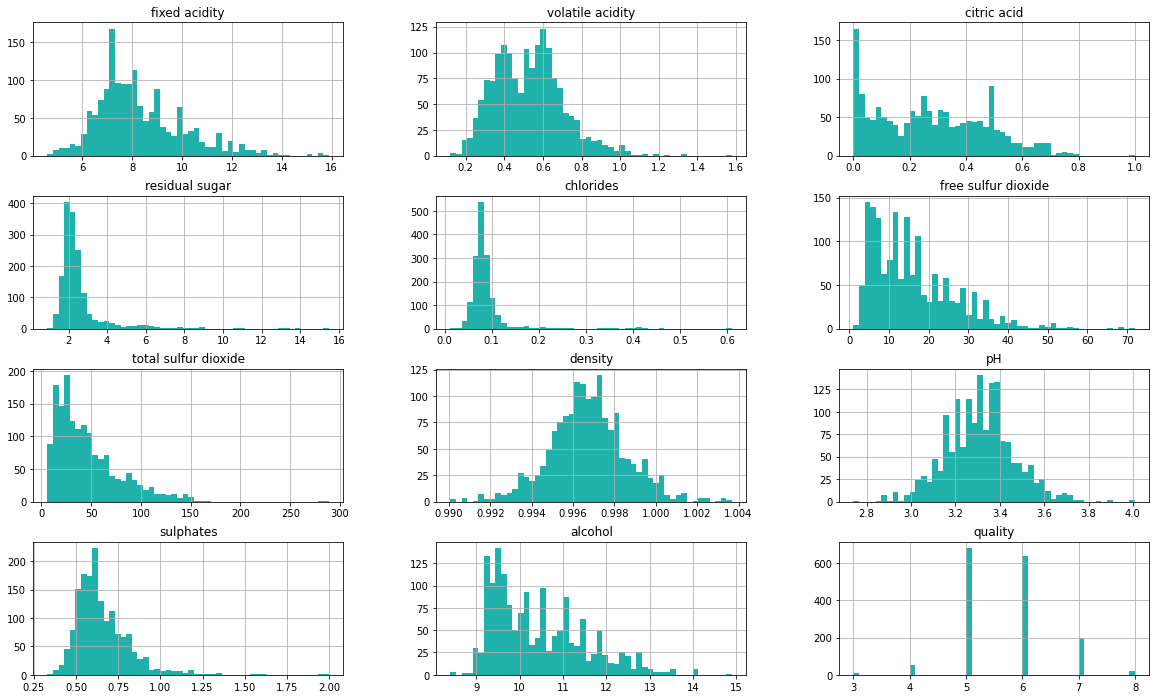

In [8]:
df.hist(bins = 50, color="lightseagreen", figsize = (20,12))
plt.show()

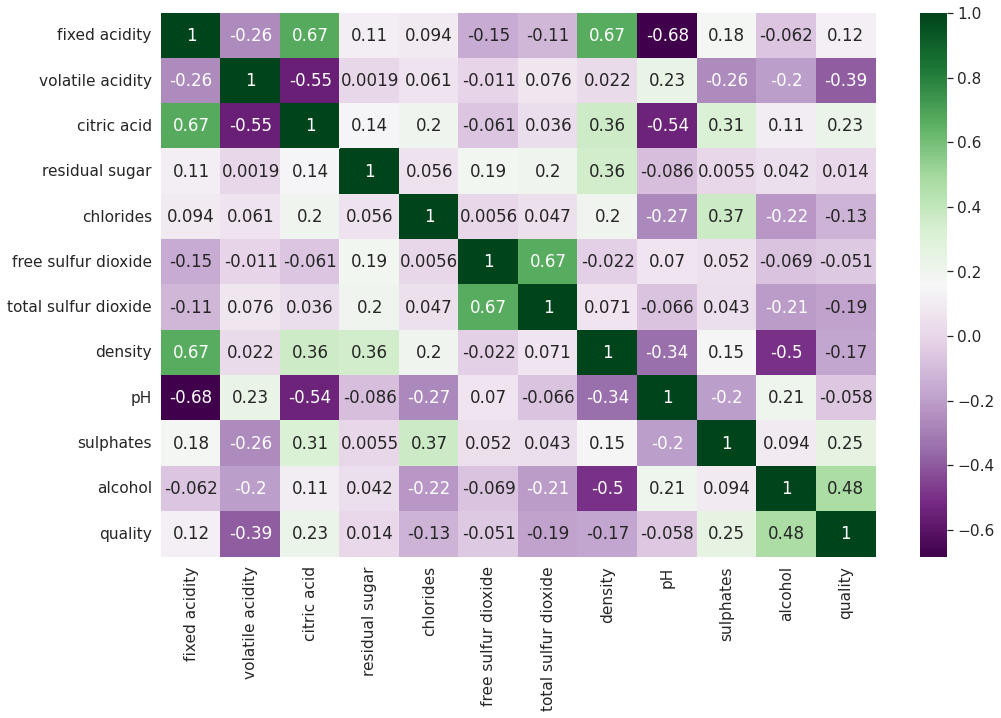

In [9]:
# Correlational heatmap

# .sns(font_scale = X) increase the x/y tick label font sizes to make it more readable 
sns.set(font_scale=1.4)
# setting up the heatmap
plt.figure(figsize=(16,10))
# aliasing .corr function as c
c = df.corr()

# setting .heatmap parameters 
sns.heatmap(c, cmap="PRGn", annot=True)
plt.show()

## Data Preprocessing

In [10]:
# Because quality is currently continuous, we need to change that to a binary classification
# "good" wine & "bad" wine.
# to do that, we'll bin (id est. create subsets that delineate between the classifiers) the target outcome- Quality

bins = (2, 6.5, 8)
# syntax - 2 = lowest value that we have on quality so start bin there, 
# second value (6) is the max value of of first bin, third value is max of second bin (no wine quality > 8)
groups = ["bad", "good"]
# for labels, you could also not use a predefined variable and just do labels = ["good", "bad"] instead of calling *groups*
df["quality"] = pd.cut(df["quality"], bins = bins, labels = groups)


In [11]:
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,bad
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad


**Encoding categorical features**

In [12]:
df["quality"].value_counts()

bad     1382
good     217
Name: quality, dtype: int64

In [13]:
# label and encode "quality" target output

# from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
encoded_quality = LabelEncoder()

In [14]:
# encoding the strings "bad","good" into 0/1 so that they're easier to parse as a numeric value
df["quality"] = encoded_quality.fit_transform(df["quality"])

In [15]:
df.quality.value_counts()
# 0 = bad
# 1 = good

0    1382
1     217
Name: quality, dtype: int64

**splitting up data into training/test sets**

- Note: if you don't specify the test_size = 0.xx parameter, it defaults to test_size = 0.25 (meaning that 25% of the data will be used for testing and the remaining 75% will be used for training.

- Not sure how much we wan't to talk about overfitting apropos of train/test ratios? (*Ask Warren*)

In [16]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(["quality"], axis=1),
 df["quality"], test_size =0.35, random_state=1)

# X_train = Train Set / X_test = Test set
# Y_train = Train Labels / Y_test = Test Labels

In [17]:
X_train.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
99,8.1,0.545,0.18,1.9,0.080,13.0,35.0,0.99720,3.30,0.59,9.0
935,8.8,0.300,0.38,2.3,0.060,19.0,72.0,0.99543,3.39,0.72,11.8
1554,6.6,0.855,0.02,2.4,0.062,15.0,23.0,0.99627,3.54,0.60,11.0


**Scaling the data**

In [18]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# output is rows by columns

(1039, 11)
(560, 11)
(1039,)
(560,)


#### Put Machine Learning library imports here. (model specific imports should go with those specific models)

In [21]:
# import em here, m'boy
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### LOGISTIC REGRESSION

In [22]:
# import libraries (Need to fix- import these more specific dependencies in cell block instead of up top to keep track)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# alias logistic regression
lr = LogisticRegression()

# fit the model -> use scaled X_train/X_test 
lr.fit(X_train, y_train)
# y_prediction for test set

lr_predict_y = lr.predict(X_test)

In [24]:
# print confusion matrixx and the accuracy score

lr_conf_matrix = confusion_matrix(y_test, lr_predict_y)
lr_acc_score = accuracy_score(y_test, lr_predict_y)

lr_conf_matrix = pd.DataFrame(
    lr_conf_matrix, index=["Actually Good | TP,FN", "Actually Not Good | FP, TN"],
     columns=["Predicted Good", "Predicted Bad" ]
)
lr_conf_matrix
print("Logistic Regression Confusion Matrix")
display(lr_conf_matrix)

print(f' Logistic Regression Score: {lr_acc_score}')
print(classification_report(y_test, lr_predict_y))

Logistic Regression Confusion Matrix


,Predicted Good,Predicted Bad
"Actually Good | TP,FN",459,26
"Actually Not Good | FP, TN",53,22


 Logistic Regression Score: 0.8589285714285714
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       485
           1       0.46      0.29      0.36        75

    accuracy                           0.86       560
   macro avg       0.68      0.62      0.64       560
weighted avg       0.84      0.86      0.85       560



### DECISION TREE MODEL

In [25]:
# Import dependencies - again, need to keep consistent (import here or up top)

from sklearn.tree import DecisionTreeClassifier

# Alias DecisionTreeClassifier
dt = DecisionTreeClassifier()
# Fit the model
dt.fit(X_train, y_train)

# Y_prediction
dt_predict_y = dt.predict(X_test)

In [26]:
# print confusion matrix and accuracy score

dt_conf_matrix = confusion_matrix(y_test, dt_predict_y)

dt_acc_score = accuracy_score(y_test, dt_predict_y)

dt_conf_matrix = pd.DataFrame(
    dt_conf_matrix, index=["Actually Good | TP, FN", "Actually Bad | FP, TN"], columns = ["Predicted Good", "Predicted Bad"]
)

dt_conf_matrix
print("Decision Tree Confusion Matrix")
display(dt_conf_matrix)
print(f'Decsion Tree Accuracy Score:{dt_acc_score}')

print(classification_report(y_test, dt_predict_y))

Decision Tree Confusion Matrix


,Predicted Good,Predicted Bad
"Actually Good | TP, FN",448,37
"Actually Bad | FP, TN",44,31


Decsion Tree Accuracy Score:0.8553571428571428
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       485
           1       0.46      0.41      0.43        75

    accuracy                           0.86       560
   macro avg       0.68      0.67      0.68       560
weighted avg       0.85      0.86      0.85       560



### Random Forest

```
- # Random Forest utilizes multiple decision trees

- # Therefore, doesn't rely on the feature importance stemming from a single decision tree.
```



In [27]:
# import random forest specific libraries

from sklearn.ensemble import RandomForestClassifier
#alais RandomForestClassifier
rf = RandomForestClassifier()

# fit the model
rf.fit(X_train, y_train)
rf_predict_y = rf.predict(X_test)

In [28]:
# Print Confusion Matrix and accuracy score

rf_conf_matrix = confusion_matrix(y_test, rf_predict_y)

rf_acc_score = accuracy_score(y_test, rf_predict_y)


rf_conf_matrix = pd.DataFrame(rf_conf_matrix,
    index=["Actually Good | TP,FN " , "Actually Bad | FP, TN"],
     columns=["Predicted Good", "Predicted Bad"]
)
rf_conf_matrix
display(rf_conf_matrix)
print("Random Forest Confusion Matrix")

print(f'Random Forest Accuracy Score: {rf_acc_score}')

print(classification_report(y_test, rf_predict_y))

,Predicted Good,Predicted Bad
"Actually Good | TP,FN",471,14
"Actually Bad | FP, TN",41,34


Random Forest Confusion Matrix
Random Forest Accuracy Score: 0.9017857142857143
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       485
           1       0.71      0.45      0.55        75

    accuracy                           0.90       560
   macro avg       0.81      0.71      0.75       560
weighted avg       0.89      0.90      0.89       560



### SUPPORT VECTOR MACHINE using Support Vector Classifier (SVC)

In [29]:
# Import SVC libraries
from sklearn.svm import SVC

# Support Vector Classifier Model
svc = SVC()
svc.fit(X_train, y_train)

svc_pred_y = svc.predict(X_test)

In [30]:
# SVC confusion matrix, accuracy score, classification report

svc_conf_matrix = confusion_matrix(y_test, svc_pred_y)

svc_acc_score = accuracy_score(y_test, svc_pred_y)

# Make the confusion matrix pretty 
svc_conf_matrix = pd.DataFrame(
    svc_conf_matrix, index=["Actually Good | TP, FN", "Actually Bad | FP, TP"],
                            columns=["Predicted Good", "Predicted Bad"]
)
print("Support Vector Classifier (SVC) Confusion Matrix")
display(svc_conf_matrix)

print(f'SVC Accuracy Score: {svc_acc_score}')

print("SVC Classification Report")
print(classification_report(y_test, svc_pred_y))


Support Vector Classifier (SVC) Confusion Matrix


,Predicted Good,Predicted Bad
"Actually Good | TP, FN",469,16
"Actually Bad | FP, TP",51,24


SVC Accuracy Score: 0.8803571428571428
SVC Classification Report
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       485
           1       0.60      0.32      0.42        75

    accuracy                           0.88       560
   macro avg       0.75      0.64      0.68       560
weighted avg       0.86      0.88      0.86       560

